In [102]:
#from stesml.model_tools import build_train_test_model
from stesml.model_tools import get_h_from_T_results
from stesml.model_tools import get_T_from_h_results

from stesml.data_tools import load_data
from stesml.data_tools import get_scenario_index
from stesml.data_tools import get_cv

from stesml.plot_tools import plot_test_results
from stesml.plot_tools import plot_average_error

from stesml.postprocessing_tools import get_m
from stesml.postprocessing_tools import get_Cp
from stesml.postprocessing_tools import get_As
from stesml.postprocessing_tools import get_Ac

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

import tensorflow.keras.backend as kb

import numpy as np

In [71]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=2,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [72]:
def get_train_data(scenario_index, train_index, target='Tavg', second_target='h'):
    train_df = load_data(scenario_index, train_index)
    X_train = train_df[["flow-time", "Tw", "Ti"]].to_numpy()
    y_train = train_df[[target, second_target, 'flow-time', 'Tw']].to_numpy()
    return X_train, y_train

In [73]:
def get_test_data(scenario_index, test_index, target='Tavg', second_target='h'):
    test_df = load_data(scenario_index, test_index)
    X_test = test_df[["flow-time", "Tw", "Ti"]].to_numpy()
    y_test = test_df[[target, second_target, 'flow-time', 'Tw']].to_numpy()
    return X_test, y_test

In [74]:
def get_train_and_test_data(scenario_index, train_index, test_index, target='Tavg', second_target='h', scale=False):
    X_train, y_train = get_train_data(scenario_index, train_index, target, second_target)
    X_test, y_test = get_test_data(scenario_index, test_index, target, second_target)
    
    if scale:
        scaler_x = StandardScaler().fit(X_train)
        X_train = scaler_x.transform(X_train)
        X_test = scaler_x.transform(X_test)
        
        scaler_y = StandardScaler().fit(y_train)
        y_train = scaler_y.transform(y_train)
        y_test = scaler_y.transform(y_test)
        
        return X_train, y_train, X_test, y_test, scaler_x, scaler_y
    
    return X_train, y_train, X_test, y_test

In [166]:
def build_NN_model(n_layers=3, n_hidden_units=50):
    model = Sequential()
    model.add(Dense(n_hidden_units, activation='relu', input_shape=(3,)))
    for i in range(n_layers-1):
        model.add(Dense(n_hidden_units, activation='relu'))
    model.add(Dense(4))
    model.compile(optimizer='adam', loss=custom_piloss, run_eagerly=True)
    model.build()
    return model

In [167]:
def get_model(model_type, parameters):
    if model_type == "XGBoost":
        # No need to return model for XGBoost
        # Model is instantiated and trained via xgboost.train in the fit_model method below
        model = None
    elif model_type == "RandomForest":
        n_estimators = parameters['n_estimators']
        max_depth = parameters['max_depth']
        max_samples = parameters['max_samples']
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_samples=max_samples, n_jobs=-1)
    elif model_type == "NN":
        n_layers = parameters['n_layers']
        n_hidden_units = parameters['n_hidden_units']
        model = build_NN_model(n_layers, n_hidden_units)
    else:
        print("Please choose either XGBoost, RandomForest, or NN for model type")
        return None
    return model

In [168]:
def fit_model(model, model_type, X_train, y_train, X_test=None, y_test=None, parameters=None):
    if X_test is None: # If no validation data is passed, validate with training data
        X_test = X_train
        y_test = y_train
        eval_name = 'train'
    else:
        eval_name = 'test'
    if model_type == "NN":
        batch_size = parameters['batch_size']
        epochs = parameters['epochs']
        model.fit(x=X_train, 
                  y=y_train,
                  batch_size=batch_size,
                  epochs=epochs, # If training ever reaches 100 epochs without early stopping, this should be increased
                  validation_data=(X_test, y_test),
                  callbacks=[earlystopping_callback])
    elif model_type == "XGBoost":
        parameters['eval_metric'] = 'rmse'
        num_boost_round = parameters['num_boost_round']
        dtrain = xgb.DMatrix(data=X_train,
                             label=y_train)
        dtest = xgb.DMatrix(data=X_test,
                             label=y_test)
        model = xgb.train(params=parameters,
                        dtrain=dtrain,
                        num_boost_round=num_boost_round, # If training ever reaches 10000 rounds without early stopping, this should be increased
                        early_stopping_rounds=20,
                        evals=[(dtest,eval_name)],
                        verbose_eval=20)
    elif model_type == "RandomForest":
        model.fit(X_train, y_train)
    return model

In [169]:
def evaluate_results(metric, y_test, y_hat):
    if metric == 'rmse':
        result = mean_squared_error(y_test, y_hat, squared=False)
    elif metric == 'r2':
        result = r2_score(y_test, y_hat)
    else:
        print('Metric must either be rmse or r2')
        return None
    return result

In [170]:
def get_predictions(model, X_test, y_test=None, scale=False, scaler_y=None, model_type='NN'):
    if model_type == 'XGBoost':
        X_test = xgb.DMatrix(data=X_test)
    y_hat = model.predict(X_test)
    if scale:
        y_hat = scaler_y.inverse_transform(y_hat)
        y_test = scaler_y.inverse_transform(y_test)
        return y_hat, y_test
    else:
        return y_hat

In [171]:
def build_train_test_model(data_dir=None, model_type='NN', target='Tavg', second_target='h', metric='rmse', scale=True, parameters=None, n_repeats=1, random_state=5):
    result_tot = 0
    addendum = list()
    
    # Get a dataframe with the filepaths of each file in the data directory
    scenario_index = get_scenario_index(data_dir)

    # Split data into train and test sets for cross-validation (80-20 train-test split)
    cv = get_cv(scenario_index, n_repeats, random_state)
    
    # Loop through the splits in cv
    for i, (train_index, test_index) in enumerate(cv.split(scenario_index.index)):

        # Get train and test data
        if scale:
            X_train, y_train, X_test, y_test, scaler_x, scaler_y = get_train_and_test_data(scenario_index, train_index, test_index, target, second_target, scale)
        else:
            X_train, y_train, X_test, y_test = get_train_and_test_data(scenario_index, train_index, test_index, target, second_target)

        # Get the model
        model = get_model(model_type, parameters)

        # Fit the model to training data
        model = fit_model(model, model_type, X_train, y_train, X_test, y_test, parameters)

        # Get predictions for test data
        if scale:
            y_hat, y_test = get_predictions(model, X_test, y_test, scale, scaler_y, model_type)
        else:
            y_hat = get_predictions(model, X_test, model_type=model_type)

        # Evaluate results
        #result = evaluate_results(metric, y_test, y_hat)
        #result_tot += result
        #result_avg = result_tot/(i+1)
        #print(f'Split #{i}, This Result: {result:.4f}, Average Result: {result_avg:.4f}')
        
        # Provide addendum for the last trained model
        if scale:
            addendum.append([y_test, y_hat, scenario_index, train_index, test_index, result, scaler_x, scaler_y])
        else:
            addendum.append([y_test, y_hat, scenario_index, train_index, test_index, result])

    return addendum

In [172]:
As = get_As()
Ac = get_Ac()

In [173]:
def custom_piloss(y_true, y_pred):
 
    # calculating squared difference between target and predicted values 
    loss = KB.square(y_pred[:,0:2] - y_true[:,0:2])  # (batch_size, 3)
    
    T_pred = y_pred[:,0]
    h_pred = y_pred[:,1]
    #flow_time = y_true[:,2]
    Tw = y_true[:,3]
    Q = y_true[:,4]
    
    #m = tf.zeros(T_pred.shape)
    #Cp = tf.zeros(T_pred.shape)
    #dT_dt = tf.zeros(T_pred.shape)
    A = tf.fill(T_pred.shape, As)
    
    f = Q - h_pred*A*(Tw - T_pred)
    
    # multiplying the values with weights along batch dimension
    #loss = loss * [0.3, 0.7]          # (batch_size, 2)
                
    # summing both loss values along batch dimension 
    loss = KB.sum(loss, axis=1)        # (batch_size,)
    loss = loss + KB.abs(f)
    
    return loss

In [174]:
data_dir = "../data/Sulfur_Models/"
model_type = 'NN' # Options: NN, XGBoost, RandomForest
target = 'Tavg' # Options: Tavg, h
second_target = 'h'
metric = 'rmse' # Options: rmse, r2
scale = True # Normalize data to a mean of 0 and STD of 1
n_repeats = 2 # Number of times to repeat 5-fold CV. Each repeat gives a different shuffle.

In [175]:
if model_type == 'NN':
    parameters = {'n_layers': 1, 'n_hidden_units': 82, 'batch_size': 2809, 'epochs': 100} # rmse = 1.699, r2 = 0.9983
    #parameters = {'n_layers': 1, 'n_hidden_units': 46, 'batch_size': 4298} # rmese = 2.06, r2 = 0.9976
elif model_type == 'XGBoost':
    parameters = {'learning_rate': 0.06600212850505194, 'subsample': 0.6242681848206246, 'colsample_bytree': 0.7982472652709917, 'num_boost_round': 10000} # rmse = 4.5927
elif model_type == 'RandomForest':
    parameters = {'n_estimators': 2}

In [176]:
tf.compat.v1.enable_eager_execution()

In [177]:
addendum = build_train_test_model(data_dir, model_type, target, second_target, metric, scale, parameters, n_repeats)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpe0d89pxp.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpe0d89pxp.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

In [10]:
# Choose the model (indexed by shuffle number) from which you would like to see results
chosen_model = addendum[9]

In [11]:
y_test = chosen_model[0]
y_hat = chosen_model[1]
scenario_index = chosen_model[2]
train_index = chosen_model[3]
test_index = chosen_model[4]

In [12]:
test_df = load_data(scenario_index, test_index)

In [13]:
test_df[target+"_hat"] = y_hat

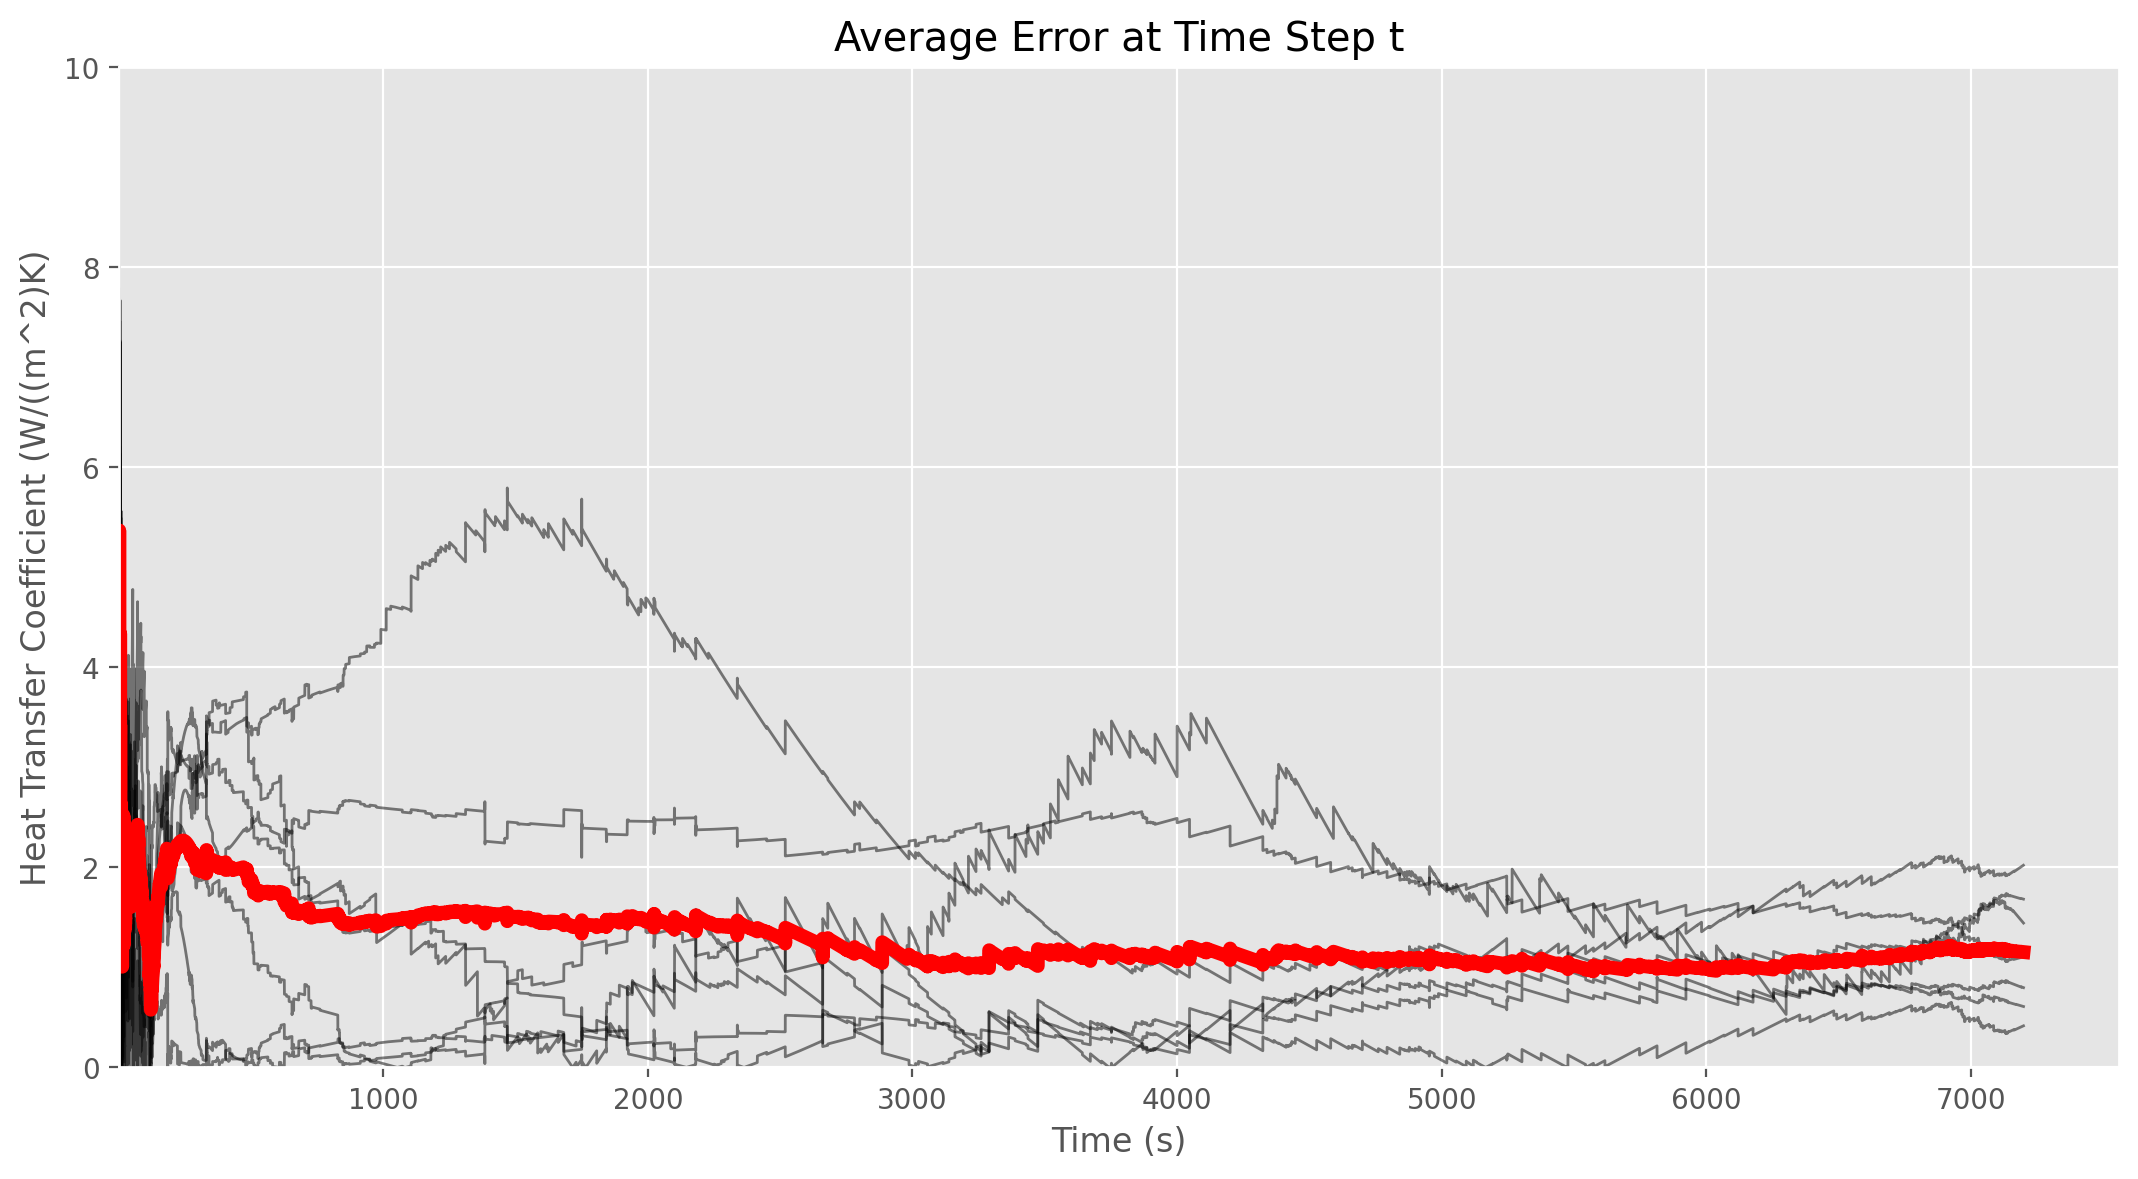

In [14]:
avg_error = plot_average_error(test_df, target=target)

<AxesSubplot:>

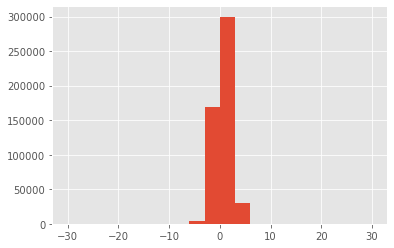

In [15]:
(test_df[target] - test_df[target+'_hat']).hist(bins=20, range=(-30, 30))

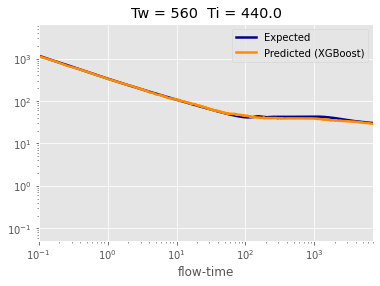

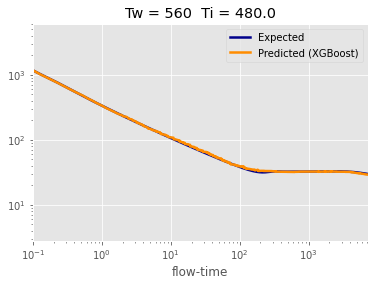

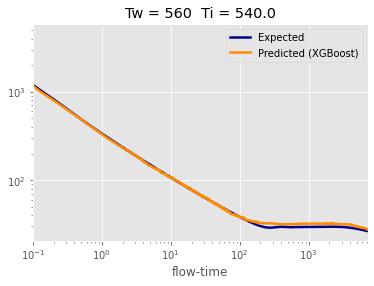

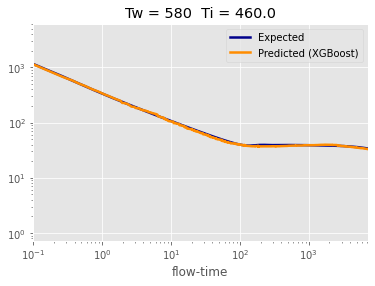

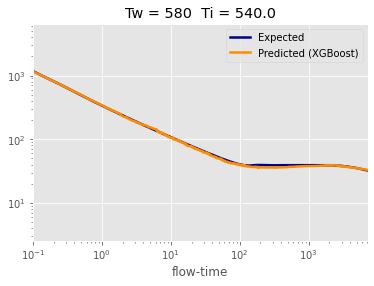

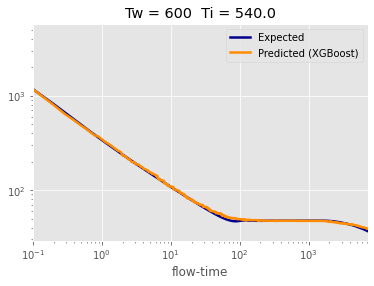

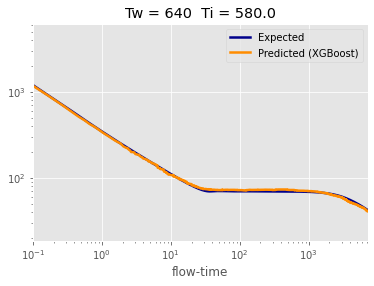

In [16]:
plot_test_results(test_df, model_type, target)

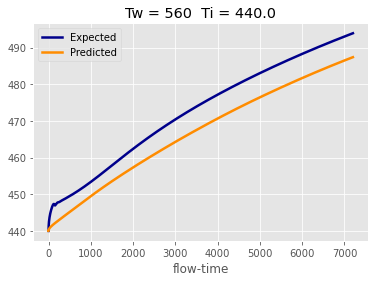

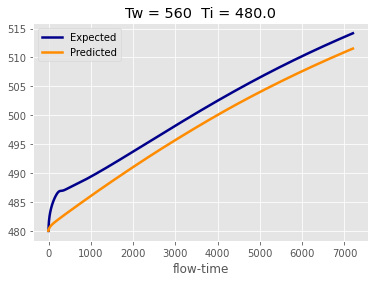

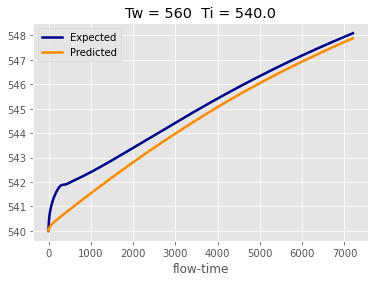

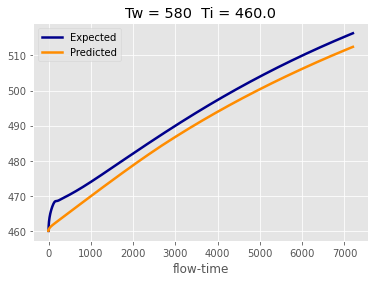

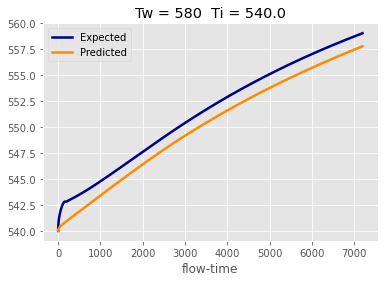

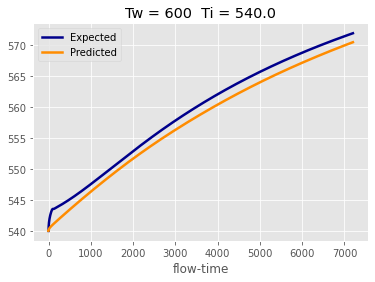

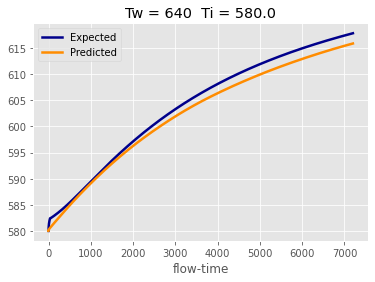

In [17]:
if target == 'Tavg':
    rmse, r2 = get_h_from_T_results(test_df, plot=True)
else:
    rmse, r2 = get_T_from_h_results(test_df, plot=True)

In [18]:
print(rmse)

3.0147395277285676


In [19]:
print(r2)

0.9951793649031446
